# Split with DecisionTree

## Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f'Length of Balrog-Bagpipes Bin{i}: {len(data[data["bin"]==i])}')

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Crate training sample

In [5]:
from plot_utils import *
import nz_utils as nz

In [6]:
data['z_mean'] = np.zeros(len(data))
pzc_array = np.vstack(data['pzc_weighted']) 
#data['z_mean'] = np.apply_along_axis(nz.mean_z, axis=1, arr=pzc_array)
data['z_mean'] = np.apply_along_axis(nz.median_z, axis=1, arr=pzc_array) # Median works better

In [7]:
pz_bin = np.array([
    np.mean(data['pzc_weighted'][data['bin'] == i], axis=0)
    for i in range(4)
])

len_pileup = 300
z3 = np.linspace(0, 2.99, len_pileup)

pz_bin_pileup = np.array([
    nz.pile_up(pz)
    for pz in pz_bin
])

pz_bin_pileup_smooth = np.array([
    nz.pileup_smooth_normalize(pz, z3)
    for pz in pz_bin
])

z_mean_pileup_smooth = np.array([nz.mean_z(pz) for pz in pz_bin_pileup_smooth])

In [8]:
stell_mean = [np.mean(data['stell_best'][data['bin']==i]) for i in range(4)]
ssfr_mean = [np.mean(data['ssfr_best'][data['bin']==i]) for i in range(4)]

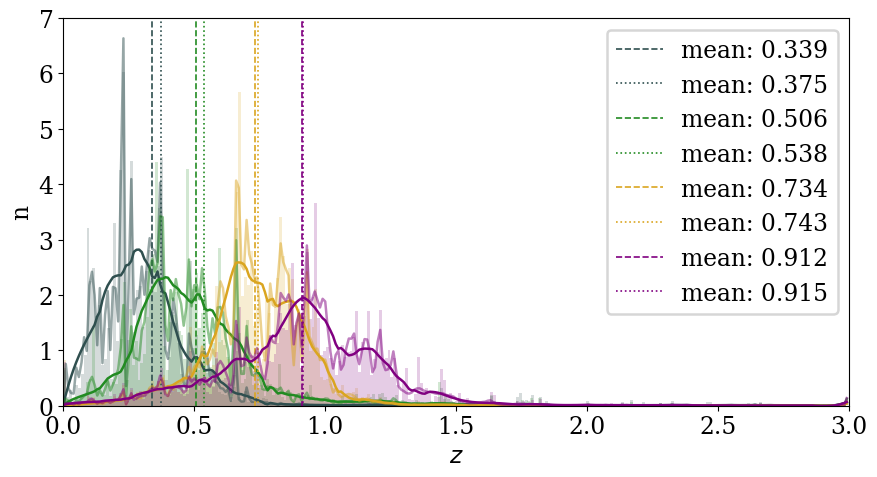

In [9]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

for i in range(4):
    ax.plot(z3, pz_bin_pileup[i], alpha=0.5, color=colors_bin[i])
    ax.plot(z3, pz_bin_pileup_smooth[i], color=colors_bin[i])
    plot_vline(ax, z_mean_pileup_smooth[i], color=colors_bin[i], label=f'mean: {z_mean_pileup_smooth[i]:.3f}')

    plt.hist(data['z_mean'][data['bin']==i], bins=400, density=True, alpha=0.2, color=colors_bin[i])
    plot_vline(ax, np.mean(data['z_mean'][data['bin']==i]), color=colors_bin[i], ls=':', 
               label=f"mean: {np.mean(data['z_mean'][data['bin']==i]):.3f}")

axis_settings(ax, z_params)
ax.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/nzs_hist_full2.png', dpi=200, bbox_inches='tight')
plt.show()

In [10]:
def assign_labels_training(data_bin, n_zbin):

    training_label = np.ones(data_bin['z_mean'].size)*(-1)
            
    z_percentiles = np.linspace(0, 100, n_zbin)
    z_edges = np.percentile(data_bin['z_mean'], z_percentiles)
    z_edges = np.unique(np.insert(z_edges[z_edges > 0], 0, 0))
    if z_edges[-1] < data_bin['z_mean'].max():
        z_edges = np.append(z_edges, data_bin['z_mean'].max())
    
    for i in range(len(z_edges) - 1):
        z_low, z_high = z_edges[i], z_edges[i + 1]
        in_z_bin = (data_bin['z_mean'] >= z_low) & (data_bin['z_mean'] <= z_high)
        z_slice = data_bin[in_z_bin]

        prop_edges = np.percentile(z_slice['stell_best'], [0, 50, 100])
        for j in range(2):
            prop_low, prop_high = prop_edges[j], prop_edges[j + 1]
            in_bin = in_z_bin & (data_bin['stell_best'] >= prop_low) & (data_bin['stell_best'] <= prop_high)
            training_label[in_bin] = j
    
    assert np.all(training_label != -1), "Some labels were not assigned"
    unique, counts = np.unique(training_label, return_counts=True)
    assert abs(counts[0] - counts[1]) / counts[0] < 1, "Label bins are imbalanced"

    return training_label.reshape(-1, 1)
    

def ensemble_training_labels(data_bin, n_zbins):

    results = [assign_labels_training(data_bin, n).flatten() for n in n_zbins]
    results = np.array(results)  # Shape: (len(n_zbins), num_labels)
    final_labels = np.round(results.mean(axis=0)).astype(int) # Majority vote across all labelings
    
    return final_labels.reshape(-1, 1)

In [11]:
data['label'] = -1

for i in range(4):
    bin_i = data[data['bin']==i]
    print(f"Length of Balrog-Bagpipes Bin{i}: {len(bin_i)}")

    training_label = assign_labels_training(bin_i, 1000)
    
    #n_zbins = [700, 800, 900, 1000]  
    #training_label = ensemble_training_labels(bin_i, n_zbins)
    
    data.loc[data['bin'] == i, 'label'] = training_label

assert not np.any(data['label'] == -1), "Unlabeled entries"

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


### Plot training sample

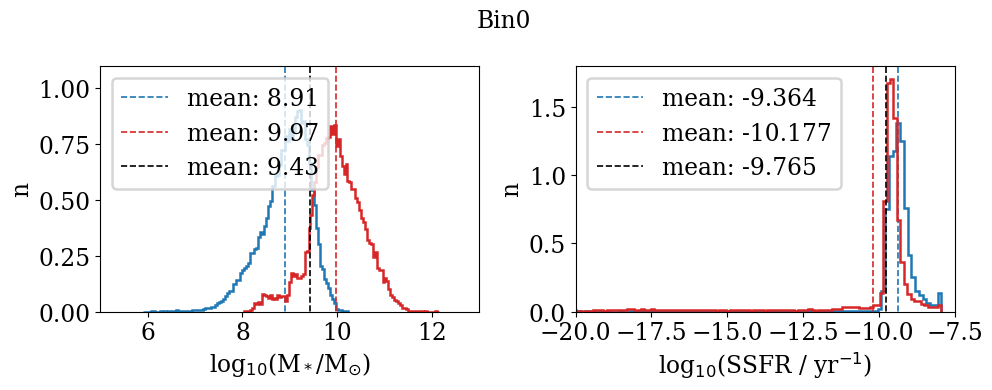

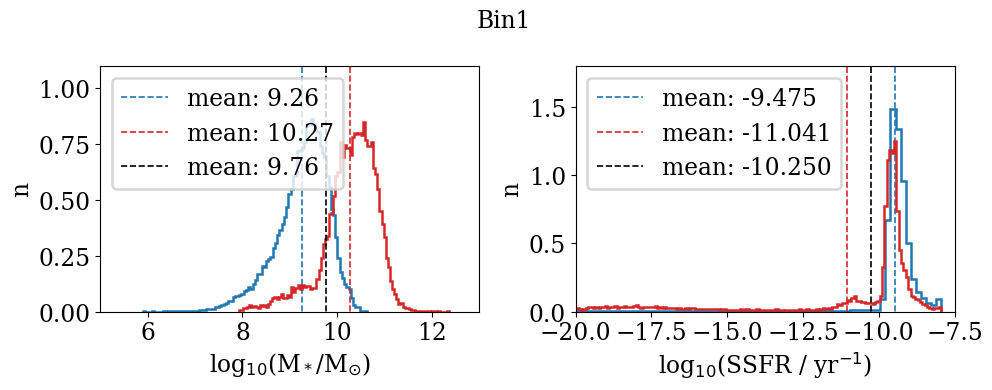

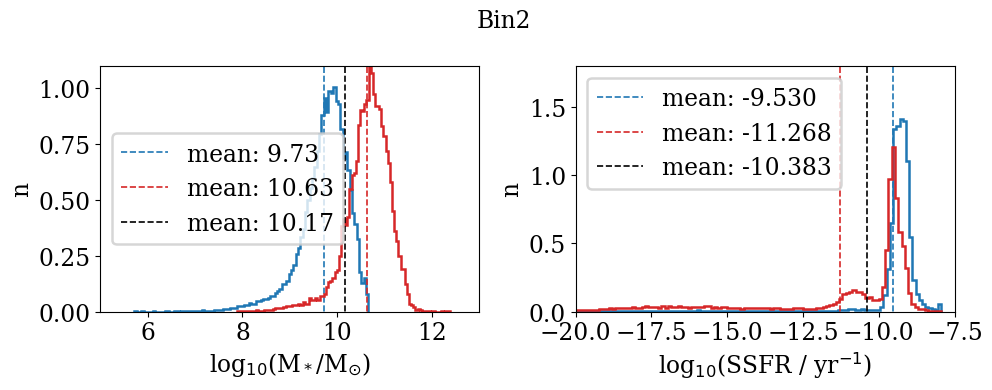

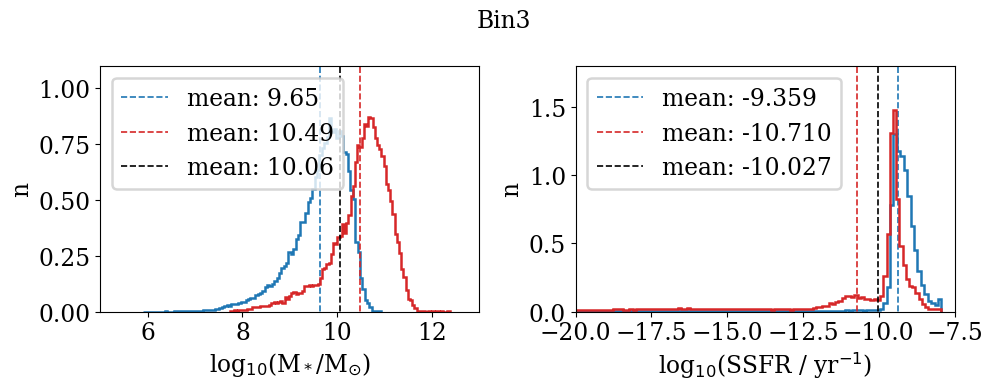

In [15]:
for i in range(4):
    fig = plt.figure(figsize=(10, 4))
    bin_i = data[data['bin']==i]
    plt.suptitle(f'Bin{i}')
    
    ax1 = plt.subplot(1,2,1)
    for j in range(2):
        ax1.hist(bin_i['stell_best'][bin_i['label']==j], bins=100, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax1, np.mean(bin_i['stell_best'][bin_i['label']==j]), color=colors_stell_bin[j], 
                   label=f"mean: {np.mean(bin_i['stell_best'][bin_i['label']==j]):.2f}")
        
    plot_vline(ax1, stell_mean[i], label=f'mean: {stell_mean[i]:.2f}')  
    axis_settings(ax1, stell_params)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    ax2 = plt.subplot(1,2,2)
    for j in range(2):
        ax2.hist(bin_i['ssfr_best'][bin_i['label']==j], bins=500, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax2, np.mean(bin_i['ssfr_best'][bin_i['label']==j]), color=colors_stell_bin[j], 
                   label=f"mean: {np.mean(bin_i['ssfr_best'][bin_i['label']==j]):.3f}")
    plot_vline(ax2, ssfr_mean[i],label=f'mean: {ssfr_mean[i]:.3f}')  
    axis_settings(ax2, ssfr_params)
    ax2.set_ylim(0, 1.8)
    ax2.legend()

    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    fig.savefig(f'figures/stell_ssfr_hist_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()

dz:        0.020
dz (mean): 0.010
dz calib:  0.015


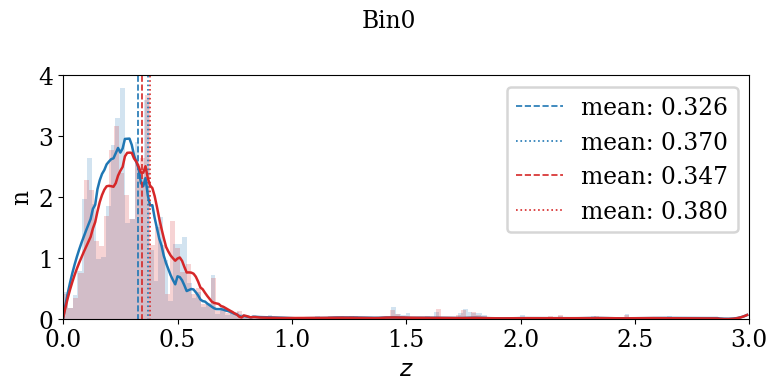

dz:        0.001
dz (mean): 0.010
dz calib:  0.011


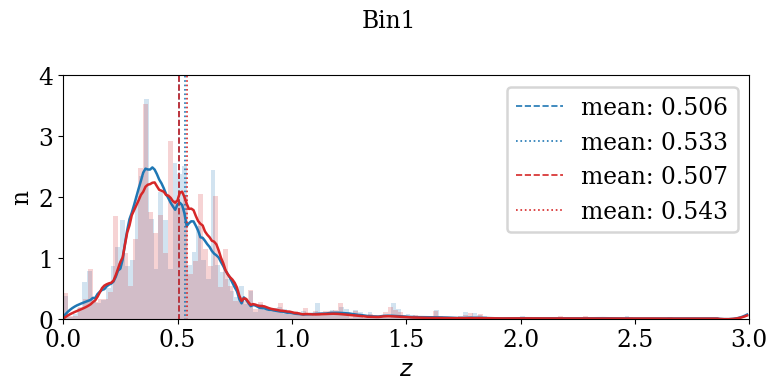

dz:        0.011
dz (mean): 0.004
dz calib:  0.008


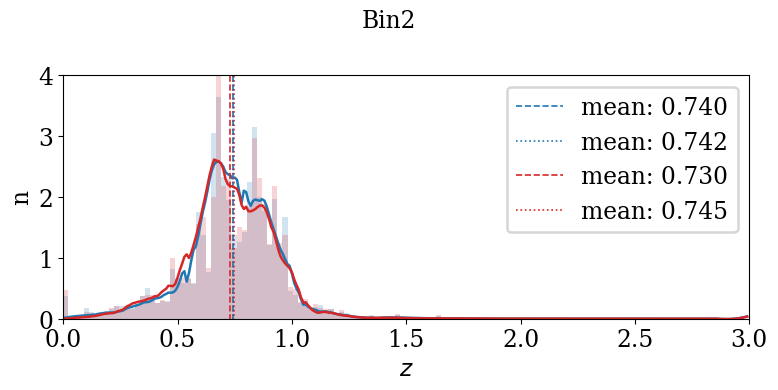

dz:        0.015
dz (mean): 0.006
dz calib:  0.015


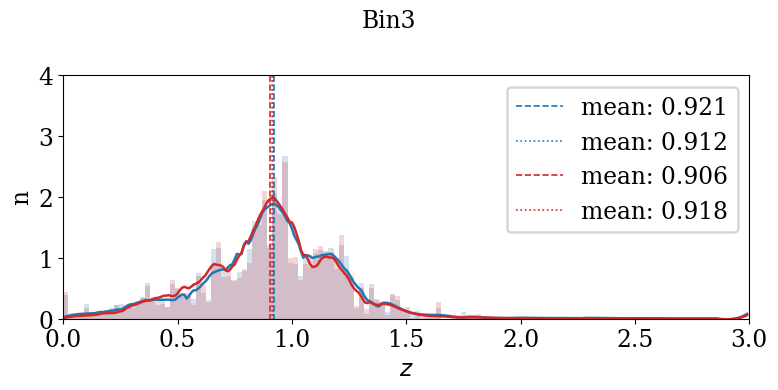

In [16]:
for i in range(4):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.gca()
    bin_i = data[data['bin']==i]
    plt.suptitle(f'Bin{i}')

    pz_bin_i = np.array([np.mean(bin_i['pzc_weighted'][bin_i['label'] == i], axis=0) for i in range(2)])
    pz_bin_i_pileup_smooth = np.array([nz.pileup_smooth_normalize(pz_bin_i[i], z3) for i in range(2)])
    meanz_bin_i_pileup_smooth = np.array([nz.mean_z(pz_bin_i_pileup_smooth[i]) for i in range(2)])

    for j in range(2):
        ax.plot(z3, pz_bin_i_pileup_smooth[j], color=colors_stell_bin[j])
        plot_vline(ax, meanz_bin_i_pileup_smooth[j], color=colors_stell_bin[j], label=f'mean: {meanz_bin_i_pileup_smooth[j]:.3f}')
        ax.hist(bin_i['z_mean'][bin_i['label']==j], bins=200, alpha=0.2, density=True, color=colors_stell_bin[j])
        plot_vline(ax, np.mean(bin_i['z_mean'][bin_i['label']==j]), color=colors_stell_bin[j], ls=':',
                   label=f"mean: {np.mean(bin_i['z_mean'][bin_i['label']==j]):.3f}")
    
    print(f'dz:        {np.abs(meanz_bin_i_pileup_smooth[0]-meanz_bin_i_pileup_smooth[1]):.3f}')
    print(f"dz (mean): {np.abs(np.mean(bin_i['z_mean'][bin_i['label']==0]) - np.mean(bin_i['z_mean'][bin_i['label']==1])):.3f}")
    print(f'dz calib:  {nz.dz_calib[i]}')

    axis_settings(ax, z_params)
    ax.set_ylim(0, 4)
    plt.legend()
    
    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    plt.savefig(f'figures/nz_hist_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()

## Train DecisionTree and save

In [12]:
import joblib
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

flux_columns = ['unsheared/flux_i', 'unsheared/flux_r', 'unsheared/flux_z']

In [13]:
def train_decisiontree(data, ibin, flux_columns=flux_columns, max_depth=20, random_state=42, min_samples_leaf=100):
    
    bin_i = data[data['bin']==ibin].copy()
    X = bin_i
    y = bin_i['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train[flux_columns], y_train) # Train on flux_columns only
    
    X_test['label_pred'] = clf.predict(X_test[flux_columns]) # Predict on test set

    # Update data with predictions
    X_train['label_pred'] = -1 # Set label_pred = -1 for training data
    X = pd.concat([X_train, X_test]) # Combine train and test back together
    data.loc[X.index, 'label_pred'] = X['label_pred']

    return clf
    

def print_report_decitiontree(X_test, title=''):

    accuracy = accuracy_score(X_test['label'], X_test['label_pred'])
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Classification Report:')
    print(classification_report(X_test['label'], X_test['label_pred']))

    conf_matrix = confusion_matrix(X_test['label'], X_test['label_pred'])
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()


def print_feature_importances(classifier, flux_columns=flux_columns):
    
    print(f'Feature Importances:')
    for col, importance in zip(flux_columns, classifier.feature_importances_):
        print(f' - {col}: {importance:.4f}')

In [14]:
decisiontree_dir = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/'
decisiontree_file_template = decisiontree_dir + 'decisiontree_bin{}.joblib'

classifiers = {}

for i in range(4):
    print(f'Training for Bin{i}')
    clf = train_decisiontree(data, i)

    decisiontree_file = decisiontree_file_template.format(i)
    joblib.dump(clf, decisiontree_file)
    print(f'Saved DecisionTree to {decisiontree_file}')

    classifiers[i] = clf

data[['bal_id', 'label', 'label_pred']].to_pickle(f'{decisiontree_dir}decisiontree_predictions.pkl')
print(f'Saved predictions')

Training for Bin0
Saved DecisionTree to /global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/decisiontree_bin0.joblib
Training for Bin1
Saved DecisionTree to /global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/decisiontree_bin1.joblib
Training for Bin2
Saved DecisionTree to /global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/decisiontree_bin2.joblib
Training for Bin3
Saved DecisionTree to /global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/decisiontree_bin3.joblib
Saved predictions


Bin0
- Number of blue galaxies: 67964
- Number of red galaxies:  54745
Number of leaves: 2910
Accuracy: 0.8538
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     62292
           1       0.89      0.80      0.84     60417

    accuracy                           0.85    122709
   macro avg       0.86      0.85      0.85    122709
weighted avg       0.86      0.85      0.85    122709



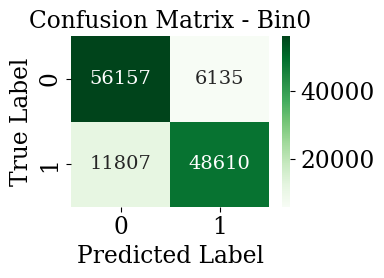

Feature Importances:
 - unsheared/flux_i: 0.0274
 - unsheared/flux_r: 0.0460
 - unsheared/flux_z: 0.9266

Bin1
- Number of blue galaxies: 66327
- Number of red galaxies:  55298
Number of leaves: 3145
Accuracy: 0.8531
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     61500
           1       0.88      0.81      0.85     60125

    accuracy                           0.85    121625
   macro avg       0.86      0.85      0.85    121625
weighted avg       0.86      0.85      0.85    121625



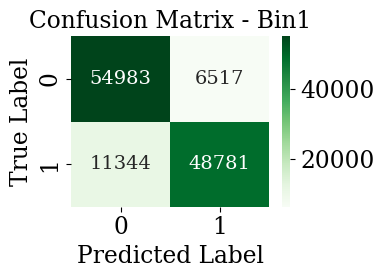

Feature Importances:
 - unsheared/flux_i: 0.0297
 - unsheared/flux_r: 0.0386
 - unsheared/flux_z: 0.9317

Bin2
- Number of blue galaxies: 64137
- Number of red galaxies:  56955
Number of leaves: 3072
Accuracy: 0.8358
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     61661
           1       0.85      0.81      0.83     59431

    accuracy                           0.84    121092
   macro avg       0.84      0.84      0.84    121092
weighted avg       0.84      0.84      0.84    121092



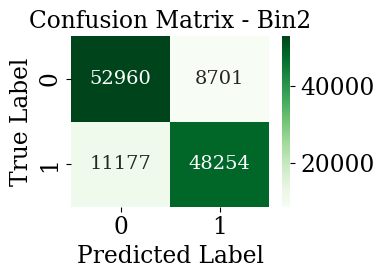

Feature Importances:
 - unsheared/flux_i: 0.0145
 - unsheared/flux_r: 0.1574
 - unsheared/flux_z: 0.8281

Bin3
- Number of blue galaxies: 67719
- Number of red galaxies:  50336
Number of leaves: 3091
Accuracy: 0.7501
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77     59429
           1       0.79      0.68      0.73     58626

    accuracy                           0.75    118055
   macro avg       0.76      0.75      0.75    118055
weighted avg       0.75      0.75      0.75    118055



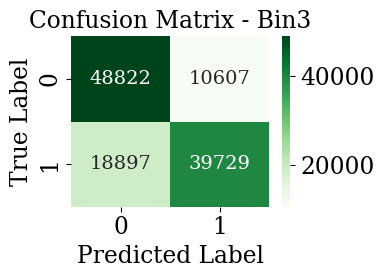

Feature Importances:
 - unsheared/flux_i: 0.0260
 - unsheared/flux_r: 0.1895
 - unsheared/flux_z: 0.7845



In [15]:
for i in range(4):
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    print(f'Bin{i}')
    print(f"- Number of blue galaxies: {len(X_test[X_test['label_pred']==0])}")
    print(f"- Number of red galaxies:  {len(X_test[X_test['label_pred']==1])}")
    print(f'Number of leaves: {classifiers[i].get_n_leaves()}')
    print_report_decitiontree(X_test, title=f'Bin{i}')
    print_feature_importances(classifiers[i], flux_columns)
    print()

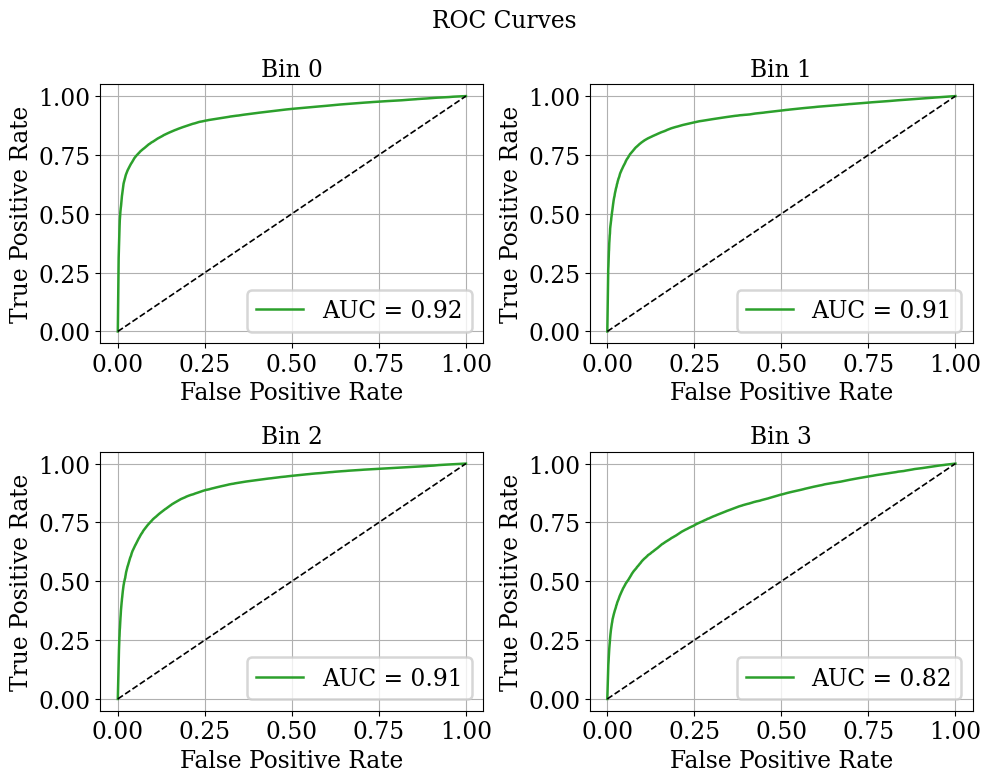

In [16]:
fig = plt.figure(figsize=(10, 8))
plt.suptitle('ROC Curves')

for i in range(4):
    clf = classifiers[i]
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]

    # Get predicted probabilities for class 1
    y_proba = clf.predict_proba(X_test[flux_columns])[:, 1]
    y_true = X_test['label']

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)

    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='tab:green')
    plt.plot([0, 1], [0, 1], lw=1.2, ls='--', color='k')
    plt.title(f'Bin {i}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
fig.patch.set_alpha(1.0)
plt.show()

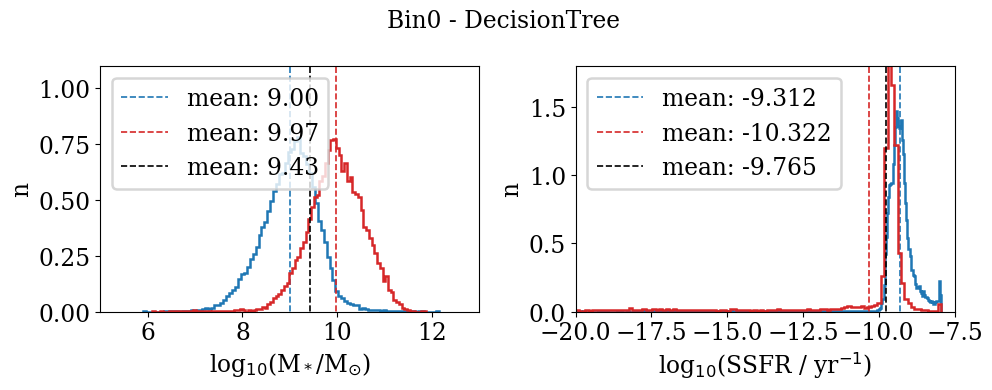

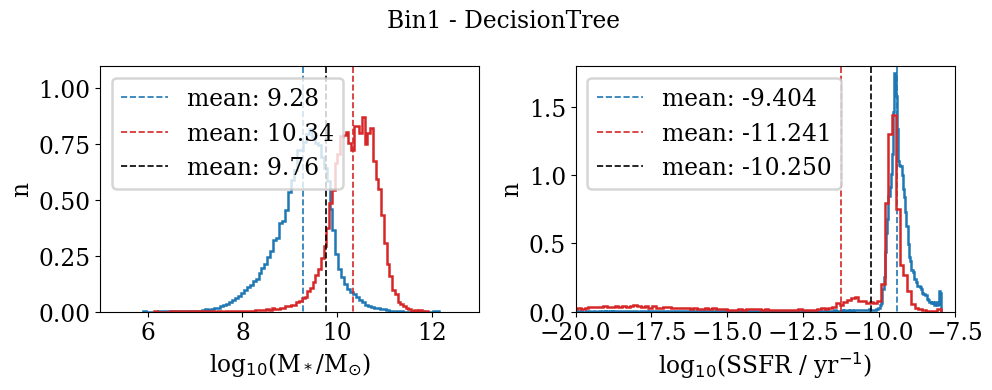

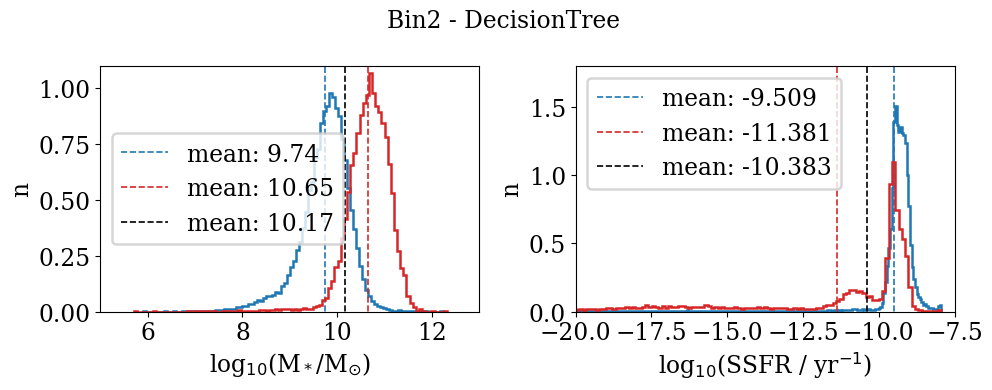

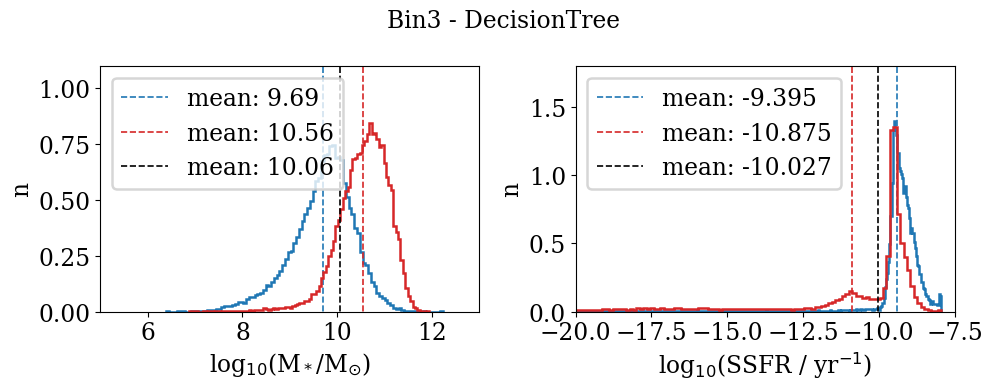

In [17]:
for i in range(4):
    fig = plt.figure(figsize=(10, 4))
    bin_i = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    plt.suptitle(f'Bin{i} - DecisionTree')
    
    ax1 = plt.subplot(1,2,1)
    for j in range(2):
        ax1.hist(bin_i['stell_best'][bin_i['label_pred']==j], bins=100, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax1, np.mean(bin_i['stell_best'][bin_i['label_pred']==j]), color=colors_stell_bin[j], 
                   label=f"mean: {np.mean(bin_i['stell_best'][bin_i['label_pred']==j]):.2f}")
        
    plot_vline(ax1, stell_mean[i], label=f'mean: {stell_mean[i]:.2f}')  
    axis_settings(ax1, stell_params)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    ax2 = plt.subplot(1,2,2)
    for j in range(2):
        ax2.hist(bin_i['ssfr_best'][bin_i['label_pred']==j], bins=500, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax2, np.mean(bin_i['ssfr_best'][bin_i['label_pred']==j]), color=colors_stell_bin[j], 
                   label=f"mean: {np.mean(bin_i['ssfr_best'][bin_i['label_pred']==j]):.3f}")
    plot_vline(ax2, ssfr_mean[i],label=f'mean: {ssfr_mean[i]:.3f}')  
    axis_settings(ax2, ssfr_params)
    ax2.set_ylim(0, 1.8)
    ax2.legend()

    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    fig.savefig(f'figures/stell_ssfr_hist_decisiontree-pred_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()

dz:        0.020
dz (mean): 0.132
dz calib:  0.015


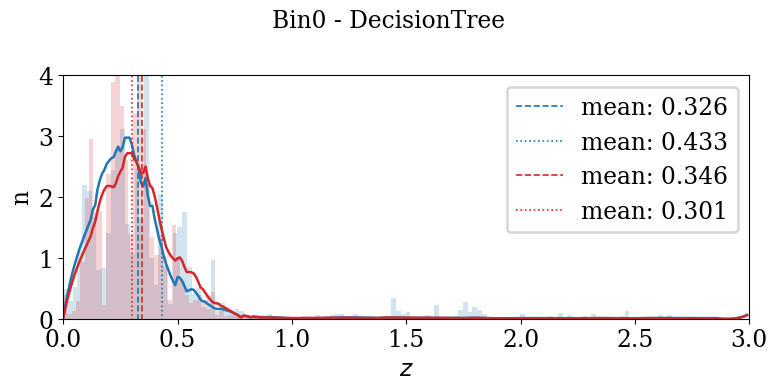

dz:        0.000
dz (mean): 0.072
dz calib:  0.011


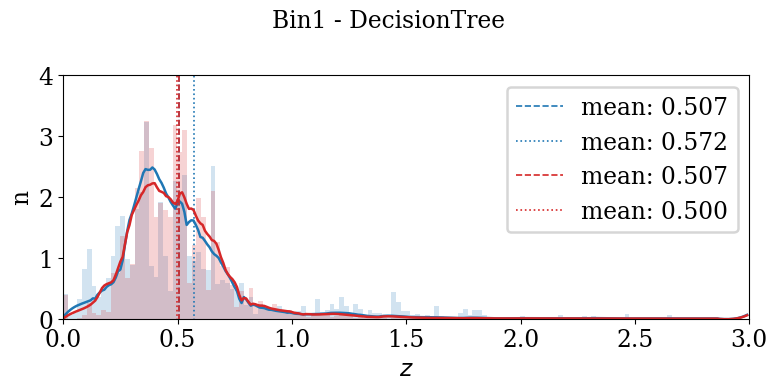

dz:        0.011
dz (mean): 0.023
dz calib:  0.008


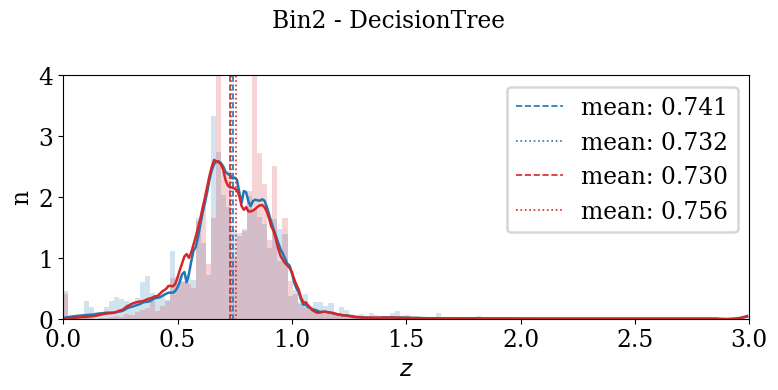

dz:        0.017
dz (mean): 0.038
dz calib:  0.015


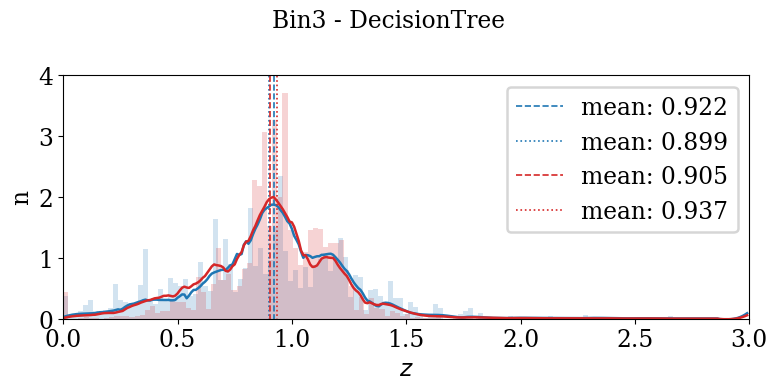

In [18]:
for i in range(4):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.gca()
    bin_i = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    plt.suptitle(f'Bin{i} - DecisionTree')

    pz_bin_i = np.array([np.mean(bin_i['pzc_weighted'][bin_i['label'] == i], axis=0) for i in range(2)])
    pz_bin_i_pileup_smooth = np.array([nz.pileup_smooth_normalize(pz_bin_i[i], z3) for i in range(2)])
    meanz_bin_i_pileup_smooth = np.array([nz.mean_z(pz_bin_i_pileup_smooth[i]) for i in range(2)])

    for j in range(2):
        ax.plot(z3, pz_bin_i_pileup_smooth[j], color=colors_stell_bin[j])
        plot_vline(ax, meanz_bin_i_pileup_smooth[j], color=colors_stell_bin[j], label=f'mean: {meanz_bin_i_pileup_smooth[j]:.3f}')
        ax.hist(bin_i['z_mean'][bin_i['label_pred']==j], bins=200, alpha=0.2, density=True, color=colors_stell_bin[j])
        plot_vline(ax, np.mean(bin_i['z_mean'][bin_i['label_pred']==j]), color=colors_stell_bin[j], ls=':',
                   label=f"mean: {np.mean(bin_i['z_mean'][bin_i['label_pred']==j]):.3f}")
    
    print(f'dz:        {np.abs(meanz_bin_i_pileup_smooth[0]-meanz_bin_i_pileup_smooth[1]):.3f}')
    print(f"dz (mean): {np.abs(np.mean(bin_i['z_mean'][bin_i['label_pred']==0]) - np.mean(bin_i['z_mean'][bin_i['label_pred']==1])):.3f}")
    print(f'dz calib:  {nz.dz_calib[i]}')

    axis_settings(ax, z_params)
    ax.set_ylim(0, 4)
    plt.legend()
    
    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    plt.savefig(f'figures/nz_hist_decisiontree-pred_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()